<a href="https://colab.research.google.com/github/AminTaheri23/Deep-Persian-NER/blob/master/Amin_Taheri_DeepNLp_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: Run with python3.10.13

In [49]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [50]:
list_classes = ['B-pers','I-pers', 'B-pro', 'I-pro','B-loc','I-loc','B-fac','I-fac','B-event','I-event','B-org','I-org','O']
list_columns = ['text','label']

### Convert labels to one-hot vectors

In [51]:
def label_to_one_hot(value):
  list_classes = ['B-pers','I-pers', 'B-pro', 'I-pro','B-loc','I-loc','B-fac','I-fac','B-event','I-event','B-org','I-org','O']
  if value == list_classes[0]:
    return [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[1]:
    return [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[2]:
    return [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[3]:
    return [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[4]:
    return [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[5]:
    return [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[6]:
    return [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  if value == list_classes[7]:
    return [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  if value == list_classes[8]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  if value == list_classes[9]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
  if value == list_classes[10]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  if value == list_classes[11]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
  if value == list_classes[12]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


### Read  train data file

In [52]:
def read_data(filename):
    df= pd.DataFrame(columns=list_columns)
    
    f = open(filename)
    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')        
        sentence.append([splits[0], splits[-1]])

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
        
    for sentence in sentences:
      words=[]
      values=[]
      for item in sentence:
        words.append(item[0])
        values.append(item[1].replace('\n',''))
      _list=[]
      _list.append(' '.join(words))
      _list.append(' '.join(values))
      df2 = pd.DataFrame([_list], columns=list_columns)
      df = pd.concat([df, pd.DataFrame([_list], columns=list_columns)], ignore_index=True)
    return df

In [159]:
train = read_data('../Part 2 - Token Classification/arman/train.txt')
validation = read_data('../Part 2 - Token Classification/arman/dev.txt')

train_val = pd.concat([train, validation], ignore_index=True)

In [160]:
train_val.head()

,text,label
0,به عنوان مثال وقتی نشریات مدافع اصول و ارزشها ...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,دکتر اصغری دبیر چهارمین همایش انجمن زمین‌شناسی...,O B-pers O B-event I-event I-event I-event I-e...
2,دکتر اکبر میرعرب در همایش بررسی و پیشگیری از ب...,O B-pers I-pers O B-event I-event I-event I-ev...
3,اردبیل ـ استاندار اردبیل گفت : به مناسبت هفته ...,B-loc O O B-loc O O O O B-event I-event O O O ...
4,حمید طاهایی افزود : برای اجرای این طرحها 0 میل...,B-pers I-pers O O O O O O O O O O O O O O O O O


## Split data, into X and Y sets

In [161]:
y_train = train_val['label']
sentences_train = train_val['text']

### Tokenization 

In [163]:
max_features = 250015
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(sentences_train)

y = [[label_to_one_hot(c) for c in ey.split(' ')] for ey in y_train]

## How do you know what is the best "maxlen" to set?
One of the ways to go about it is to see the distribution of the number of words in sentences.

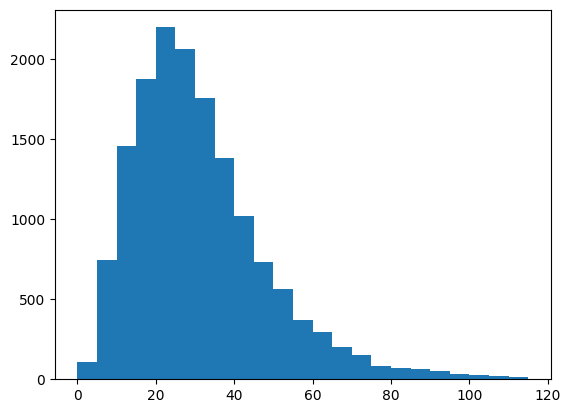

In [164]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,120,5))
plt.show()
# 120 is a good maxlen

In [165]:
maxlen = 60
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y_t = pad_sequences(y, maxlen=maxlen)

##  load our embeddings model into a dictionary 

In [166]:
def load_word2vec_embeddings(file_path):
    embeddings_index = {}
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                values = line.split()

                if len(values)==301:
                    word = values[0]    
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
                elif len(values)==302:
        #print(len(value))
                    word = values[0]+'\u200c'+values[1]   
                    coefs = np.asarray(values[2:], dtype='float32')
                    embeddings_index[word] = coefs
                elif len(values)==303:
                    word = values[0]+'\u200c'+values[1]+'\u200c'+values[2]  
                    coefs = np.asarray(values[3:], dtype='float32')
                    embeddings_index[word] = coefs
            except Exception as inst:
                    print(inst)
    
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(tokenizer.word_index) + 1
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, 300))
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')
        
    del(embeddings_index)
    return embedding_matrix

file_path = '../PersianNER/wor2vec_skipgram300d.txt'
embeddings_matrix = load_word2vec_embeddings(file_path)

total embedded: 13048 common words


### ‌Bidirectional-LSTM + F1

In [170]:
from tensorflow import keras
import tensorflow.keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [171]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.models import Model


inp = Input(shape=(maxlen, ))
emb = Embedding(len(tokenizer.word_index)+1, embeddings_matrix.shape[1],weights=[embeddings_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(150, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(emb)
x_rnn = Bidirectional(LSTM(150, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = tf.keras.layers.Add()([x, x_rnn]) 
#x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(300, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(13, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', get_f1])
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_25 (Embedding)    (None, 60, 300)              5462700   ['input_17[0][0]']            
                                                                                                  
 bidirectional_44 (Bidirect  (None, 60, 300)              541200    ['embedding_25[0][0]']        
 ional)                                                                                           
                                                                                                  
 bidirectional_45 (Bidirect  (None, 60, 300)              541200    ['bidirectional_44[0][0

In [172]:
batch_size = 512
epochs = 5
hist = model.fit(X_t,y_t, batch_size=batch_size, epochs=epochs, validation_split=0.2)#class_weight={'O':0.04, 'B-pers':0.20}) 

Epoch 1/5
25/25 [==============================] - 99s 4s/step - loss: 0.1408 - accuracy: 0.4476 - get_f1: 0.5203 - val_loss: 0.0396 - val_accuracy: 0.4652 - val_get_f1: 0.6567
Epoch 2/5
25/25 [==============================] - 89s 3s/step - loss: 0.0391 - accuracy: 0.5436 - get_f1: 0.8202 - val_loss: 0.0354 - val_accuracy: 0.4795 - val_get_f1: 0.8791
Epoch 3/5
25/25 [==============================] - 90s 4s/step - loss: 0.0368 - accuracy: 0.5777 - get_f1: 0.8531 - val_loss: 0.0348 - val_accuracy: 0.8703 - val_get_f1: 0.8930
Epoch 4/5
25/25 [==============================] - 86s 3s/step - loss: 0.0363 - accuracy: 0.6438 - get_f1: 0.8503 - val_loss: 0.0349 - val_accuracy: 0.8917 - val_get_f1: 0.8787
Epoch 5/5
25/25 [==============================] - 84s 3s/step - loss: 0.0360 - accuracy: 0.6916 - get_f1: 0.8358 - val_loss: 0.0346 - val_accuracy: 0.9207 - val_get_f1: 0.9046


## training/validation loss plots

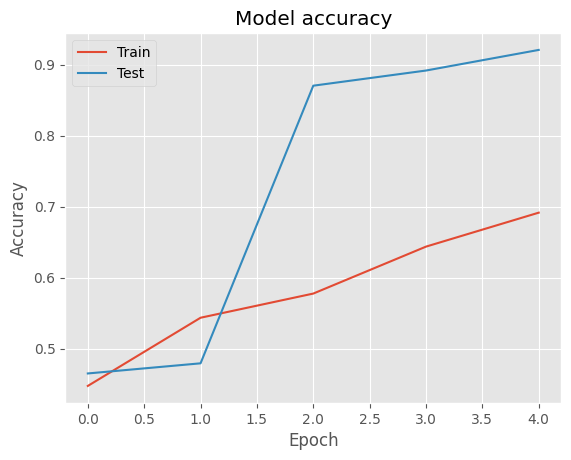

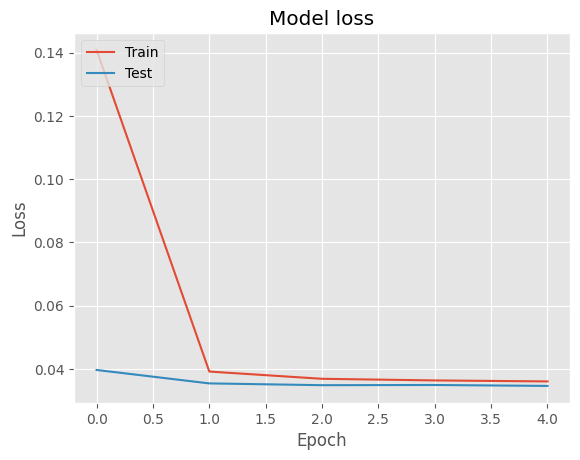

In [173]:
# Visualize the Model
plt.style.use("ggplot")
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()